# Recommendation Systems
## Assignment 1: Matrix Factorization & Evaluation

**By:**  
Group 4

Oren Avidan

Maytar Shalit

<br><br>

**The goal of this assignment is to:**
- Understand the details of matrix factorization algorithm
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- Please use English language only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used.  
- You should implement the matrix factorization algorithm by yourself using only basic Python libraries (such as numpy).



<br><br><br><br>

**Grading:**
- Q1 - 0 points - Data exploration
- Q2 - 25 points - Evaluation metrics
- Q3 - 50 points - Models implementation and evaluation
  -  A. Popularity basline model: 10 points
  -  B. Explicit Matrix Factorization: 25 points
  -  C. Train & HyperParams Search: 5 points 
  -  D. Bias only model: 5 points
  -  E. Discussion: 5 points
- Q4 - 25 points - Similarity & Explainability 

`Total: 100`

**Prerequisites**

In [2]:
!pip install --quiet zipfile36

**Imports**

In [3]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [4]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [6]:
random.seed(123)

# Question 1:

## Data exploration 

Download the MovieLens 100K rating dataset.   
Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item.  
Include additional exploration you find relevant to questions 2 and 3.  
Discuss your insights and possible challenges related to the prediction task described in question 2.  

In [7]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

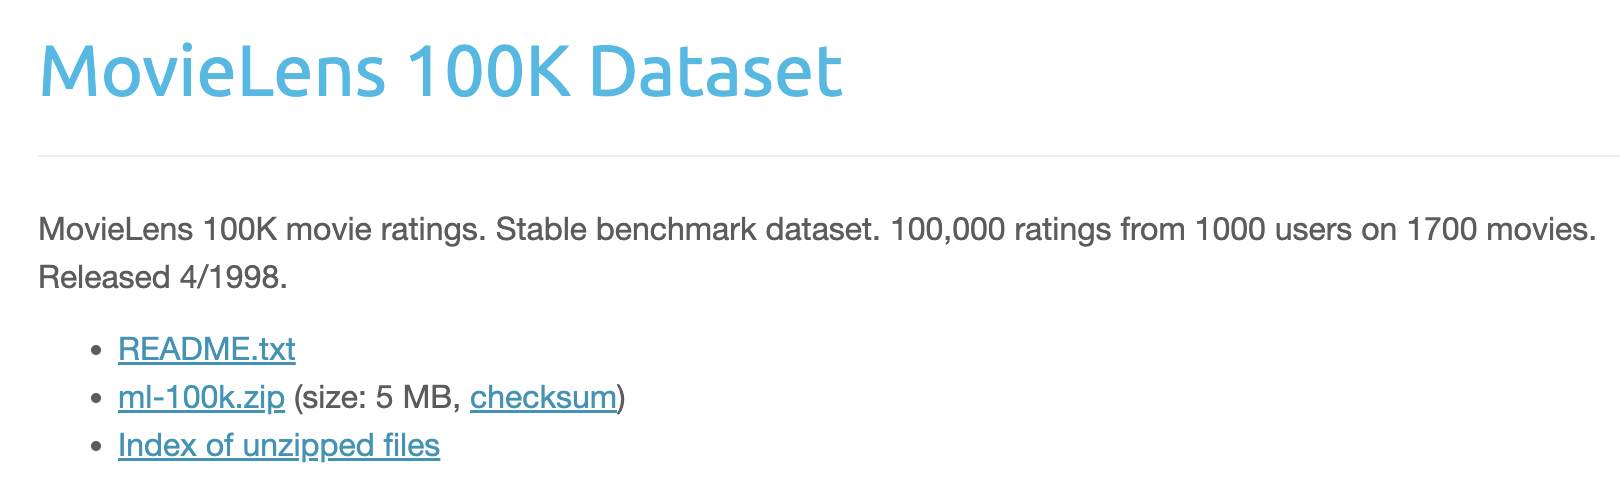

**Columns Names**

In [8]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [9]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [10]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [11]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are mathing the info data file

In [12]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

**Matrix:**

In [13]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br><br><br><br>

**Explore ratings data:**

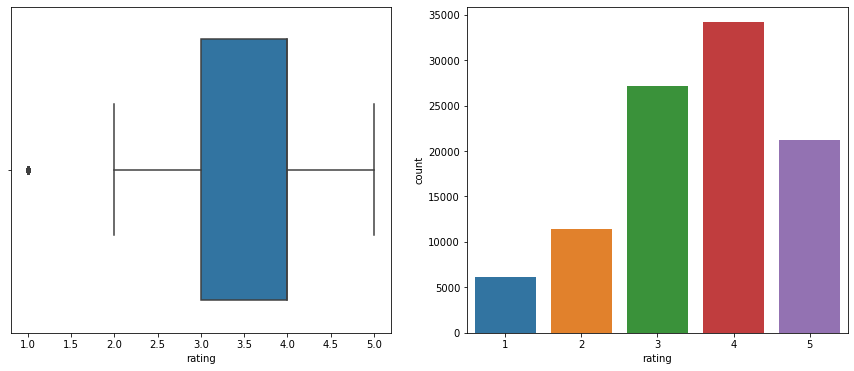

In [14]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

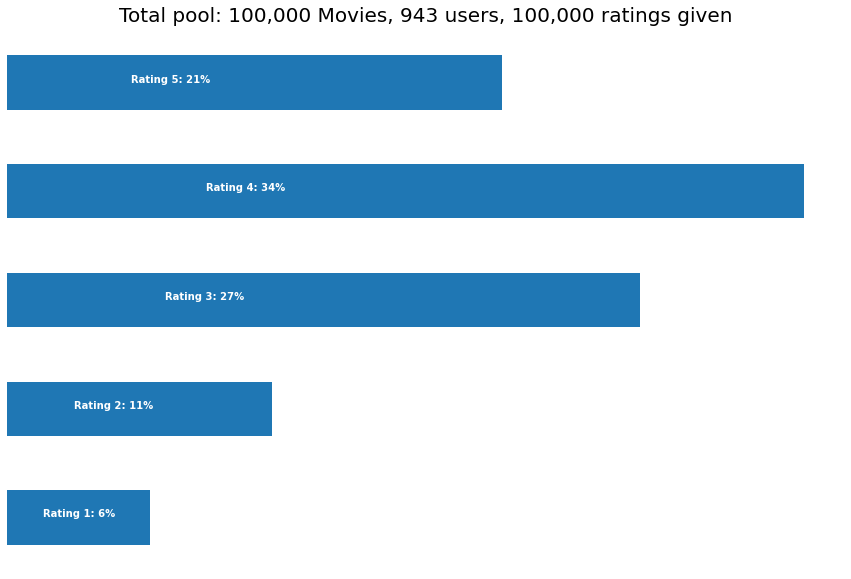

In [15]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.count()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

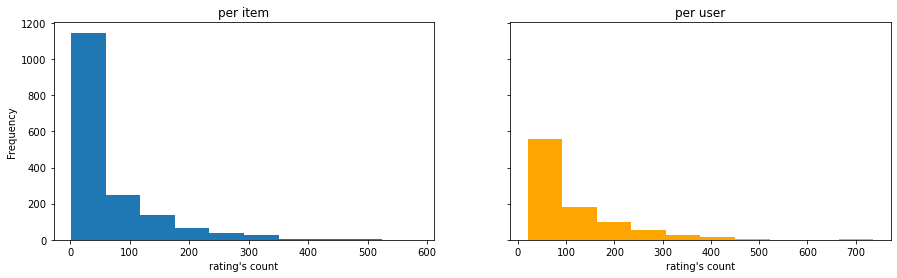

In [16]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

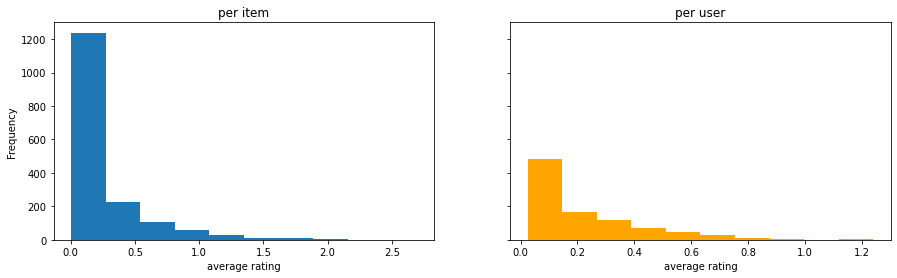

In [17]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

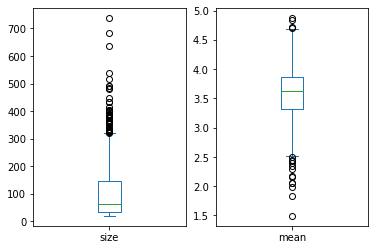

In [18]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

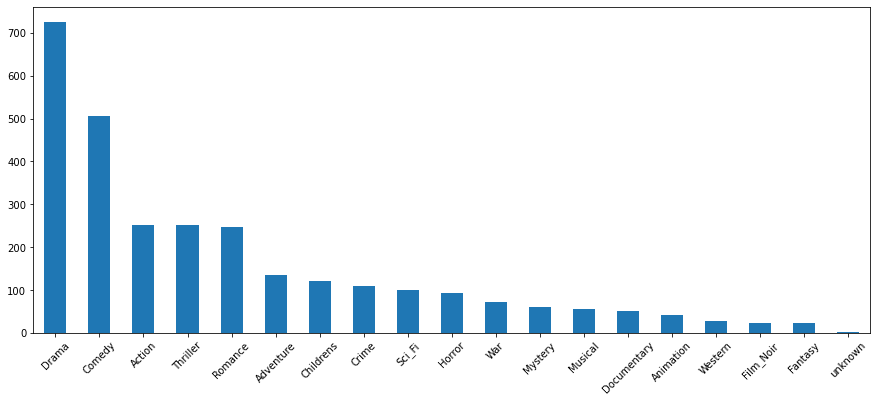

In [19]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [20]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('Sparsity is equal to {}%'.format(str(matrix_sparsity)) )

Sparsity is equal to 93.7%


<br><br><br><br><br><br>

# Question 2:


## Evaluation Metrics

Please create a class to calculate the following metrics on two different dataset (df_true,df_pred):
- RMSE
- MRR
- nDCG

**Notes:**
- Please read this great blog post: 
<a href='https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832'>MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them </a>
- Please consider edge cases - NaN, Null, Zeros, out of bound, eval time, etc.
- You can work with Dataframe or with Numpy arrays(matrix)
- You may remove/add params to these functions
- Please use only pytonic code!

In [21]:
class my_metrics():
        
    def RMSE(df_true: pd.DataFrame, df_pred: pd.DataFrame, lower_bound=1, upper_bound=5) -> float:
        """
        Function receives two DataFrames of movies and returns the RMSE. 
        The df_pred consists of the projected values and df_true consists of the real ratings of the users.  
        *The df the function receives only the movies (columns) that were recommended by the system*.
        
        :param df_true: df consisting the projected values for each given data point 
        :type df_true: df
        :param df_pred: df consisting the real values for each given data point 
        :type df_pred: df
        :return: the RMSE score of the two arrays
        :rtype: float
        """
        # firsly we will replace all values in df_pred with 0, where df_true equals zero (so we will not take them into account in calculating the RMSE score
        df_pred_rmse = df_pred.where(df_true!=0, 0)

        df_true_rmse = df_true.where(df_pred!=0, 0)

        # we will sum all values and then divide by the number of values
        number_of_values = np.count_nonzero(df_pred_rmse)

        # summing all values:
        total_sum_of_squares = (((df_pred_rmse - df_true_rmse) ** 2).sum(axis=1).sum())

        # returning RMSE
        return np.sqrt(total_sum_of_squares / number_of_values)
    
    
    def MRR(df_true: pd.DataFrame, df_pred: pd.DataFrame, lower_bound=1, upper_bound=5, top_n=5, threshold=3) -> float:
        """
        The function recieves two ratings data frames - true and predicted, *only with the recommended movies*. 
        The df_pred contatins the ratings matrix with the ratings recommended by the system to the user.
        The df_user will contatin df of movies with the ratings of the users. 
        
        :param df_true: df consisting the projected values for each given user
        :type df_true: df
        :param df_pred: a df consisting the real values for each given user
        :type df_pred: df
        :return: the MRR score of the two arrays
        :rtype: float
        """
        no_of_users = np.array(df_true).shape[0]
        rr_sum = 0 
        
        for user in df_true.index:
            rr_sum += my_metrics.MRR_for_user(user_true=pd.Series(df_true.loc[user]), user_pred=pd.Series(df_pred.loc[user]), lower_bound=lower_bound, upper_bound=upper_bound, top_n=top_n, threshold=threshold)
        
        return rr_sum / no_of_users
    
    def MRR_for_user(user_true: pd.Series, user_pred: pd.Series, lower_bound, upper_bound, top_n, threshold) -> float:
        """
        Function receives two data Series (user_true and user_pred) and returns the RR of the user.

        Note that in MRR we don't care about the order the user chose the items but whether it had chosen any of them at all.

        If the user didn't choose anything - the function will return 0.

        :param user_true: Series consisting the projected values for each given user
        :type user_true: pd.Series
        :param user_pred: a Series consisting the real values for each given user
        :type user_pred: pd.Series
        :return: the reciprocal rate (RR) score of a specific user.
        :rtype: float
        """
        user_pred[user_pred<threshold] = 0
        
        # first we will sort the items we recommended by rating from largest to smallest
        items_pred = user_pred.sort_values(ascending=False, ignore_index=False).nlargest(n=top_n).index
        
        # saving the movies id's the user rated
        items_true = user_true[user_true>0].dropna().index
                
        # find the index of the highest ranked product that the user has chosen  
        highest_rank = np.isin(items_pred, items_true).nonzero()
        
        if np.size(highest_rank, axis=None) == 0: # If the user did not rate any of the recommended movies
            return 0
            
        else:  
            return 1 / (highest_rank[0][0] + 1)
    
    
    def NDCG(df_true: pd.DataFrame, df_pred: pd.DataFrame, lower_bound=1, upper_bound=5, top_n=5) -> float:
        """
        The function calculates the average NDCG of all users (averages the NDCG_for_user by the number of users).
        The function receives two DataFrames - 
            (1) df_true presents the true ratings df
            (2) df_pred presents the predicted ratings df

        The function calculated the NDCG for all users.

        :return: ndcg - which is the average ndcg score above all users
        :rtype: float
        """
        # please use NDCG_for_user
    
        ndcg_sum = 0 
        
        for user in df_pred.index:
            
            ndcg_sum += my_metrics.NDCG_for_user(user_pred=df_pred.loc[user, :], user_true=df_true.loc[user, :], 
                                                 lower_bound=lower_bound, upper_bound=upper_bound, top_n=top_n)
        
        
        return ndcg_sum / df_pred.shape[0]
        
    def NDCG_for_user(user_true: pd.Series, user_pred: pd.Series, lower_bound=1, upper_bound=5, top_n=5) -> float:
        """
        The function calcaulates the NDCG score of each user. the function sorts and uses the DCG function to calculate the score.

        The function receives-
        * user_true which represents the relevancy the user gave to each movie, and 
        * user_pred which the list of relevancies the system provided.

        :return: the DCG score of the list
        :rtype: float
        """
        # please use DCG function        
        # IDCG - 
        # we will first need to sort the movies by the user's relevancy
        user_true_sorted_by_user = user_true.sort_values(ascending = False)[:top_n]
        idcg_per_user = my_metrics.DCG(rel=user_true_sorted_by_user, n=top_n)
        
        
        # DCG 
        # sort user_pred by system rank
        user_pred = user_pred.sort_values(ascending=False)[:top_n]
        
        # sort user_true by the indices of top recommended movies
        user_true_sorted_by_sys = user_true[user_pred.index]
        
        dcg_per_user = my_metrics.DCG(rel=user_true_sorted_by_sys, n=top_n)
        if idcg_per_user != 0:
            return dcg_per_user / idcg_per_user
        else:
            return 0
    
    def DCG(rel: pd.Series, n: int=5) -> float:
        # please implement the DCG formula
        rel = rel.reset_index(drop=True)
        dcg = (((2 ** rel) - 1) / np.log2(rel.index + 2)).sum()
        
        return dcg

    
    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


Checking your evaltuation metrics and performence:

In [22]:
%time my_metrics.get_error(ratings,ratings)

Wall time: 4.81 s


{'RMSE': 0.0, 'MRR_5': 1.0, 'MRR_10': 1.0, 'NDCG_5': 1.0, 'NDCG_10': 1.0}

<br><br><br><br>

# Question 3

### Models Implementation & Evaluation
Split the data to train and test.  
Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics (based on Q2 implementation) to evaluate your recommender system. For the MRR and NDCG metrics use cutoff value of 5. Items with a rating of 3 and above are considered as relevant.   

Produce a learning curve graph and a table which compares the results of the following algorithms: 
 - Bias only based model
 - Simple popularity based model
 - Different choices of the latent factor dimension regularization, learning rate. 



**Save final results**

In [23]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

**Choose fold**

In [24]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(1))

train.shape,test.shape

((943, 1682), (943, 1682))

### A. Popularity model

Recommend the most popular movies which have more than 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [25]:
class POP():

    def __init__(self, df_train, M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = df_train
        self.min_movie_ratings = M
        self.recommended = ratings.copy()
        self.recommended[:] = 0 
        self.fit_time = 0
        self.recommended_movies_indices = 0
        
    def fit(self):
        """
        The function fits the data based on popularity based model. 
        The function finds the aveage score of movies with more than 10 ratings. 
        After that, it filters out movies with average score lower than 3, and chooses the M movies with the highest average score.
        
        :return: the rating matrix showing only the recommended movies
        :rtype: pandas df
        
        """       
        # please record the training time in fit_time
        min_relevant_rating = 3

        beginning_time = time.time()


        # find the number of ratings each movie got:
        num_of_ratings_received = pd.DataFrame(self.df_train[self.df_train>0].count(axis='rows'))
        num_of_ratings_received.columns = ['count']

        # show only the movies that their number of ratings is greater than self.min_movie_ratings
        movies_with_enough_ratings = num_of_ratings_received[num_of_ratings_received['count'] >= self.min_movie_ratings].index

        # calcuate the mean rating for those movies     
        filtered_movies = self.df_train[movies_with_enough_ratings]
        filtered_movies = pd.DataFrame(filtered_movies[filtered_movies > 0].mean())
        filtered_movies.columns = ['average rating']
        
        # getting the names of the movies with average rating larger than 3
        recommended_movies = filtered_movies[filtered_movies['average rating'] > min_relevant_rating]

        # seperating the indices of the relevant movies
        recommended_movies_indices = np.array(recommended_movies.index)
        
        # saving the values of the relevant movies
        recommended_movies_values = np.squeeze (np.array(recommended_movies.values), axis=1) # squeeze due to technival issue
        
        self.recommended_movies_indices = recommended_movies_indices
        self.recommended[recommended_movies_indices] = recommended_movies_values
                
        
        self.fit_time = time.time() - beginning_time

        
    def predict(self, N=10):
        # return a series with the mean rating and the movie's id
        self.recommended_movies_indices = self.recommended[self.recommended>0].mean().sort_values(ascending = False)[:N].index

        return self.recommended_movies_indices
        
        
        
    def get_rmse(self, test):
        # please use my_metrics    
        test = test[test > 0].dropna(how='all').fillna(0) 
        pred = self.recommended[test.columns].loc[test.index.values]
    
        return my_metrics.RMSE(df_true=test ,df_pred=pred)
        

    
    def get_mrr(self,test, k=10, threshold=3):
        """
            
        :return: x
        :rtype: x
        
        """      
        # Please use my_metrics
        
        # our actual here will be the test set only with the recommended movies 
        test = test[self.predict(N=k)]
        test = test[test > 0].dropna(how='all').fillna(0) 
        pred = self.recommended[test.columns].loc[test.index.values]

        return my_metrics.MRR(df_true=test ,df_pred=pred, top_n=k, threshold = threshold)
        
    
    
    def get_ndcg(self, test, k=5):
        # please use my_metrics      
    
        test = test[self.predict(N=k)]
        test = test[test > 0].dropna(how='all').fillna(0) 
        
        pred = self.recommended[test.columns].loc[test.index.values]
    
        return my_metrics.NDCG(df_true=test ,df_pred=pred, top_n=k)    

    
    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()]['movie_title']

Checking your model and performance:

In [26]:
# create popularity model
model_pop = POP(train)

# train model
%timeit model_pop.fit()

# record model results
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)

# display
final_results

49.8 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.049325,0.999926,0.398485,0.304062,0.549121,0.46808


In [27]:
model_pop.predict(100)

Int64Index([ 408,  169,  318,  483,   64,   12,   50,  603,  114,  513,  178,
             357,  480,  427,   98,  963,  134,  313,  488,  966,  251,  127,
             479,  174,  285,  515,  272,  657,  474,  641,  199,  320,  172,
             524,  173,  484,  187,  302, 1142,  511,  316,  191,  528,   89,
             493,  487,  223,  185,  166,   22,  190,  192,  170,  647,  478,
             498,  489,  100,   48,  633,  520,  505,  315,  165,  496,  923,
             606,  661,   79,   23,  490,  654,  124,  180,   30,  651,   45,
             197,  168,  589, 1039,  611,  601,  430,  194,  132,  613,  615,
             607,   83,  136,  659,  527,  519,  213, 1007,  656,  694,  494,
             189],
           dtype='int64', name='item_id')

In [28]:
print ("recommended are:")
model_pop.recommended

recommended are:


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,3.89295,3.180952,0.0,3.526316,3.304348,3.4,3.798046,3.99422,3.833333,3.876712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### B. Explicit Matrix Factorization

**Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.**

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [26]:
class MF():
    
    def __init__(self, df_train, n_factors=10, only_bias=False):
        self.df_train = df_train
        self.n_factors = n_factors
        self.only_bias = only_bias
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        
        # biases
        self.original_bias_global = np.sum(df_train) / np.count_nonzero(df_train)
        self.original_bias_rows = np.sum(df_train,axis=1) / np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols = np.sum(df_train,axis=0) / np.count_nonzero(df_train,axis=0)
        
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
            self.weights_user_feature_mat = np.zeros((self.n_rows, self.n_factors))
            self.weights_movie_feature_mat = np.zeros((self.n_cols, self.n_factors))
        else:
            self.weights_user_feature_mat = np.random.uniform(size=(self.n_rows, self.n_factors))
            self.weights_movie_feature_mat = np.random.uniform(size=(self.n_cols, self.n_factors))
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows = np.random.uniform(size=(self.n_rows))
        self.bias_cols = np.random.uniform(size=(self.n_cols))
            
        
    def fit(self,
            n_iterations = 1,
            learning_rate = 1e-1,
            regularization = 1e-2,
            convergence = 1e-5,
            error = 'RMSE',
            initilize_training = True,
            verbose = True):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
                  
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        self.fit_time = None
        start_time = time.time()

        # please use the class functions 
        
        for current_iteration in range(self.n_iterations):

            self.history.append(self.get_rmse(self.df_train))
            
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration != 0 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            
            self.rows_indices = np.arange(self.n_rows)
            self.cols_indices = np.arange(self.n_cols)
            self.optim_GD()
        
        end_time = time.time()
        self.fit_time = end_time - start_time

    
    def converging(self):
        np.abs(self.history[-1] - self.history[-2]) < self.ϵ

                  
    def optim_GD(self):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        # collect the index row and col for all values in df_train that has rating != 0
        non_zero_idx = [[row, col] for row in range(self.n_rows) for col in range(self.n_cols) if self.df_train[row, col] != 0]
        # iterate over all values in self.df_train
        for rate_val in non_zero_idx:
            pred = np.dot(self.weights_user_feature_mat[rate_val[0]], self.weights_movie_feature_mat[rate_val[1]].T) + self.bias_global + self.bias_rows[rate_val[0]] + self.bias_cols[rate_val[1]]
            error = self.df_train[rate_val[0]][rate_val[1]] - pred
            if not self.only_bias: # update weights
                original_weights_user_feature_mat = self.weights_user_feature_mat[rate_val[0]].copy()
                self.weights_user_feature_mat[rate_val[0]] += self.α * (error * self.weights_movie_feature_mat[rate_val[1]] - self.λ * self.weights_user_feature_mat[rate_val[0]])
                self.weights_movie_feature_mat[rate_val[1]] += self.α * (error * original_weights_user_feature_mat - self.λ * self.weights_movie_feature_mat[rate_val[1]])
            # update bias
            self.bias_rows[rate_val[0]] += self.α * (error * self.bias_rows[rate_val[0]])
            self.bias_cols[rate_val[1]] += self.α * (error * self.bias_cols[rate_val[1]])       
                  
    def step_rows(self):
        # make sure the signs are exacly as formula, For example:  YtY,λI,etc.
        pass
    
                  
    def step_cols(self):
        pass
    
        
    def predict(self, N=10):
        return np.dot(self.weights_user_feature_mat, self.weights_movie_feature_mat.T) + self.bias_global + self.bias_rows[:,np.newaxis] + self.bias_cols[np.newaxis,:]
        
        
    def get_rmse(self, test):
        # please use my_metrics
        pred = self.predict()
        return my_metrics.RMSE(pd.DataFrame(test), pd.DataFrame(pred))
    
    
    def get_mrr(self, test, k=10, threshold=3):
        # Please use my_metrics
        pred = self.predict()
        pred = pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=np.arange(1, pred.shape[1] + 1))
        return my_metrics.MRR(test, pred, top_n=k, threshold=threshold)
    
    
    def get_ndcg(self, test, k=5):        
        # please use my_metrics
        pred = self.predict()
        pred = pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=np.arange(1, pred.shape[1] + 1))
                
        return my_metrics.NDCG(test, pred, top_n=k)

Checking your model and performance:

In [27]:
# create MF model
model_mf = MF(train.values,n_factors=5,only_bias=False)

# train model
%time model_mf.fit(n_iterations=2,verbose=False,regularization=0.01,convergence=1e-100,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test), model_mf.get_mrr(test,k=5), model_mf.get_mrr(test,k=10), model_mf.get_ndcg(test,k=5), model_mf.get_ndcg(test,k=10)

# display
final_results

CPU times: user 3.07 s, sys: 1.96 s, total: 5.03 s
Wall time: 2.53 s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.026402,1.654394,0.398485,0.304062,0.549121,0.46808
1,MF,2.531982,1.276480,0.039413,0.046862,0.018347,0.01917


<br><br><br>

## C. Train & HyperParams Search 


**Different choices of the latent factor dimension, regularization, learning rate.**

and Find best hyperparameters


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    



In [28]:
# given params
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-5, 1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]

results = pd.DataFrame(columns=['Latent_factors', 'Iterations', 'Learning_Rate', 'Regularization', 'Convergence', 'RMSE', 'MRR_5', 'MRR_10', 'NDCG_5', 'NDCG_10', 'History', 'Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations': n_iter, 'Latent_factors': lf, 'Learning_Rate': lr, 'Regularization': reg, 'Convergence': conv}

                    # initialize model
                    mf = MF(train.values, n_factors=lf)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter, verbose=False, learning_rate=lr, regularization=reg, convergence=conv)
                    
                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic['RMSE'] = mf.get_rmse(test) 
                    dic['MRR_5'] = mf.get_mrr(test, k=5) 
                    dic['MRR_10'] = mf.get_mrr(test, k=10) 
                    dic['NDCG_5'] = mf.get_ndcg(test, k=5)
                    dic['NDCG_10'] = mf.get_ndcg(test, k=10)         
                
                    # record model history
                    dic['History'] = mf.history 
                    
                    # add experiment
                    results = results.append(dic, ignore_index=True)


results

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,5,20,0.001,0.01,0.00001,1.544758,0.006875,0.008807,0.001689,0.001835,"[2.5853537208383592, 1.8922202851404648, 1.620...",25.618952
1,5,20,0.001,0.01,0.00100,1.540074,0.010322,0.011975,0.001919,0.001998,"[2.6091274556642583, 1.894475619555314, 1.6194...",25.544869
2,5,20,0.001,0.10,0.00001,1.526932,0.011435,0.013246,0.003240,0.003230,"[2.589371256516128, 1.8821741944745127, 1.6076...",25.457548
3,5,20,0.001,0.10,0.00100,1.492671,0.005019,0.007380,0.000959,0.001775,"[2.603640137202613, 1.8932700974324903, 1.6169...",25.363254
4,5,20,0.001,1.00,0.00001,1.384411,0.004277,0.005161,0.001018,0.001528,"[2.616374819206057, 1.7872008835217394, 1.5183...",26.218050
5,5,20,0.001,1.00,0.00100,1.377914,0.006875,0.007417,0.001768,0.001445,"[2.629144440528175, 1.7951334730125448, 1.5245...",26.524446
6,5,20,0.010,0.01,0.00001,1.364691,0.038971,0.045941,0.016448,0.019157,"[2.587034372089075, 1.1604274498215903, 1.0794...",25.528500
7,5,20,0.010,0.01,0.00100,1.362920,0.035578,0.041548,0.014160,0.016073,"[2.5825740558915165, 1.1612432258236438, 1.080...",25.577139
8,5,20,0.010,0.10,0.00001,1.286197,0.037610,0.045143,0.016202,0.018434,"[2.6221518196050204, 1.1553468773701552, 1.076...",25.858760
9,5,20,0.010,0.10,0.00100,1.284517,0.032909,0.039639,0.014762,0.017086,"[2.610918298000246, 1.1535014701929451, 1.0745...",25.906070


**Training history:**

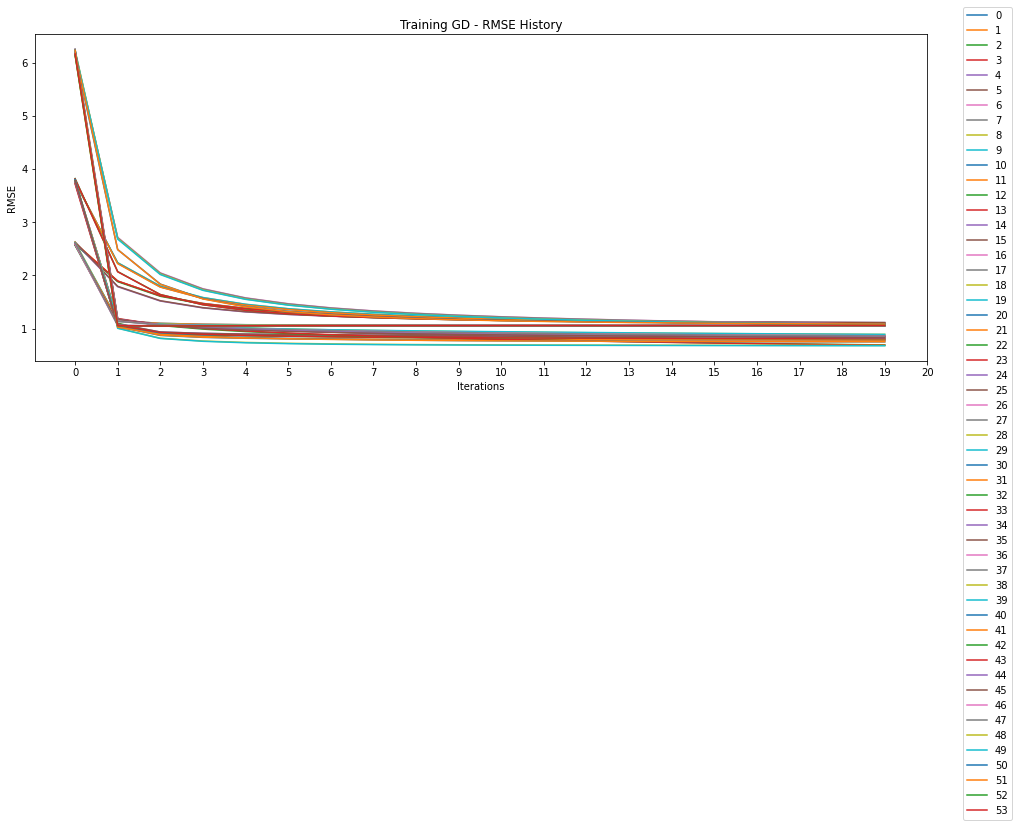

In [29]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Focus on the top 3:**

In [30]:
results.loc[results.sort_values(by=["RMSE"]).index[:3]]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
35,10,20,0.1,1.0,0.00100,1.182810,0.000831,0.003247,0.000437,0.001410,"[3.780301654837033, 1.0568620373060094, 1.0507...",26.681650
53,20,20,0.1,1.0,0.00100,1.182950,0.001273,0.003993,0.000499,0.001583,"[6.162338408211279, 1.0557356801159836, 1.0481...",26.876244
34,10,20,0.1,1.0,0.00001,1.182992,0.000477,0.003379,0.000294,0.001493,"[3.7581460027374956, 1.0560015733254224, 1.050...",26.763772


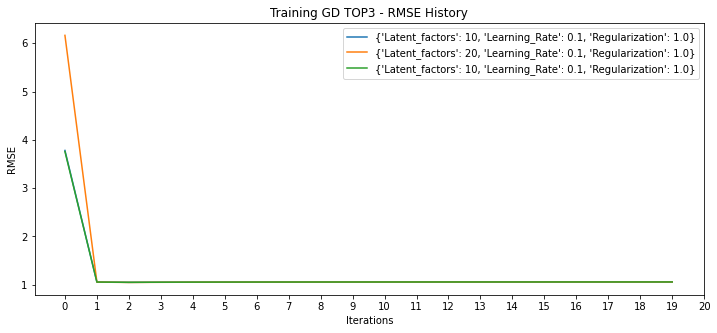

In [31]:
lines = lines[results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();


**Q: is there a clear winner?**  

### Answer
Since we have 5 different hyper-parameters that we're examining - we will need to deep dive before providing a clear answer.

In the training of the model we tested 5 differennt hyper-parameters - n_iterations, convergence, latent_factors, regularization, and learning_rate.

We can see that the best learning raet would be 0.1 and for regularization we will get 1. The only thing that chnages is the latent factors.

We can see that even after 1 itereation the results are all the same - so basically all different hyper-parameters will give the same result after 1 iteration. 

If so, it seems that there is no clear winner if we iterate more than 1 time.

We can also see that the differences between the 3 results barely exists, and not significant. 

Nevertheless, for the 'final_results' df we will take the hyper-parameters of the first result.


Please add your winner to `final_results` dataframe.

In [32]:
# create MF model
model_mf = MF(train.values,n_factors=20,only_bias=False)

# train model
%time model_mf.fit(n_iterations=20,verbose=False,regularization=1,convergence=0.001,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'MF_best', model_mf.fit_time, model_mf.get_rmse(test), model_mf.get_mrr(test,k=5), model_mf.get_mrr(test,k=10), model_mf.get_ndcg(test,k=5), model_mf.get_ndcg(test,k=10)

# display
final_results

CPU times: user 33.1 s, sys: 19.3 s, total: 52.4 s
Wall time: 26.7 s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.026402,1.654394,0.398485,0.304062,0.549121,0.468080
1,MF,2.531982,1.276480,0.039413,0.046862,0.018347,0.019170
2,MF_best,26.670996,1.183258,0.000619,0.001654,0.000294,0.000518


**Understanding The Effect - `Latent Factors` - Your Conclusions:**

The latent factors in this case are comprised of two matrices: first, user feature matrix, which describes the user feature prefrence. Second, movie feature matrix, which quantifies given scores of each feature for each movie.
In addition, the user data has dependencies between the different movies, since users share have similar taste.
This is why it is then possible to create a sufficient prediction as of the prefrences of the population, based on some shared features. Meaning, if two users like, for instance, action and drama, it is reasonable to assume that thw same movies would be good to recommand for both.
Given that, minimizing the amount of latent factors may indeed come in handy for predicting good recommandations using less computational power.

Learning 

Learning rate is one of the most impacting hyper-paramter. The learning rate should be chosen carefully, as if it were to be too high or too low may lead to overfit or underfit very easily.
Learning rate that is too low, will learn the training data to thoroughly, fixtating and adjusting the model based on every small change of the training, which will eventually lead to model overfitting.
On the other hand, choosing learning rate value that is too high, might lead to a non converging model. This is due to large adjestments of the weights, which might cause "loosing" of the locak minima.

**Understanding The Effect - `Regularization` - Your Conclusions:**

The regularization is a parameter which allows us to better control (or regular) the amount of adjustment we want to apply on the model weights.
This optimization helps preventing overfitting of the model to the training data.

<br><br><br>

## D. Bias only based model
#### Repeat the explicit matrix factorization implementation for the bias only model. Please use the same visualizations.  

<br>

**Hyperparams search + train the model :**

In [52]:
# given params
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-5, 1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]

bias_only_results = pd.DataFrame(columns=['Latent_factors', 'Iterations', 'Learning_Rate', 'Regularization', 'Convergence', 'RMSE', 'MRR_5', 'MRR_10', 'NDCG_5', 'NDCG_10', 'History', 'Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations': n_iter, 'Latent_factors': lf, 'Learning_Rate': lr, 'Regularization': reg, 'Convergence': conv}

                    # initialize model
                    mf = MF(train.values, n_factors=lf,only_bias=True)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter,verbose=False ,learning_rate=lr,regularization=reg,convergence=conv)
                    
                    
                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic['RMSE'] = mf.get_rmse(test) 
                    dic['MRR_5'] = mf.get_mrr(test, k=5) 
                    dic['MRR_10'] = mf.get_mrr(test, k=10) 
                    dic['NDCG_5'] = mf.get_ndcg(test, k=5)
                    dic['NDCG_10'] = mf.get_ndcg(test, k=10)         
                
                    # record model history
                    dic['History'] = mf.history 
                    
                    # add experiment
                    bias_only_results = bias_only_results.append(dic, ignore_index=True)

bias_only_results

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,5,20,0.001,0.01,0.00001,1.312335,0.000530,0.001122,0.000011,0.000032,"[1.5870463857283041, 1.4598228138332134, 1.387...",14.366284
1,5,20,0.001,0.01,0.00100,1.303964,0.001591,0.001873,0.000181,0.000162,"[1.5550610017191802, 1.4444608468828966, 1.377...",14.174540
2,5,20,0.001,0.10,0.00001,1.308540,0.000000,0.000718,0.000000,0.000174,"[1.5382305682997264, 1.4344246487834458, 1.370...",13.987301
3,5,20,0.001,0.10,0.00100,1.306260,0.001060,0.001193,0.000034,0.000028,"[1.5426160202807369, 1.4358870851408794, 1.370...",14.422778
4,5,20,0.001,1.00,0.00001,1.321091,0.001679,0.001944,0.000058,0.000104,"[1.5525432047876104, 1.4432401809410997, 1.376...",14.148252
5,5,20,0.001,1.00,0.00100,1.302751,0.001856,0.002165,0.000299,0.000235,"[1.5751811656717063, 1.4528201486832895, 1.382...",13.970240
6,5,20,0.010,0.01,0.00001,1.201068,0.008307,0.021607,0.002901,0.010447,"[1.5441365804371763, 1.1943290440788825, 1.139...",14.354210
7,5,20,0.010,0.01,0.00100,1.200780,0.008784,0.016779,0.004373,0.006896,"[1.5683954523510493, 1.1960912232208902, 1.140...",14.237774
8,5,20,0.010,0.10,0.00001,1.202824,0.004648,0.013814,0.001928,0.006151,"[1.5501785902269563, 1.1938136186569648, 1.138...",14.146441
9,5,20,0.010,0.10,0.00100,1.202491,0.001007,0.003470,0.000408,0.001442,"[1.512083802389363, 1.1887653893469887, 1.1368...",14.013404


**Choose your top3 models:**


In [53]:
bias_only_results.loc[results.sort_values(by=["RMSE"]).index[:3]]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
35,10,20,0.1,1.0,0.00100,1.182794,0.000831,0.003570,0.000437,0.001528,"[1.5529440700352284, 1.0788782408612112, 1.066...",14.075418
53,20,20,0.1,1.0,0.00100,1.182914,0.000831,0.003917,0.000437,0.001656,"[1.555947197600027, 1.0794831010995884, 1.0664...",14.027934
34,10,20,0.1,1.0,0.00001,1.183067,0.001007,0.003747,0.000484,0.001561,"[1.557769843644198, 1.079155363015819, 1.06640...",14.061965


**Add your winner to `final_resuls` dataframe:**

In [54]:
# create MF model
model_mf_bias_only = MF(train.values,n_factors=20,only_bias=True)

# train model
%time model_mf_bias_only.fit(n_iterations=20,verbose=False,regularization=0.1,convergence=0.001,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'MF_bias_only_best', model_mf_bias_only.fit_time, model_mf_bias_only.get_rmse(test), model_mf_bias_only.get_mrr(test,k=5), model_mf_bias_only.get_mrr(test,k=10), model_mf_bias_only.get_ndcg(test,k=5), model_mf_bias_only.get_ndcg(test,k=10)

# display
final_results

CPU times: user 20.3 s, sys: 18.8 s, total: 39.1 s
Wall time: 14 s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.026402,1.654394,0.398485,0.304062,0.549121,0.468080
1,MF,2.531982,1.276480,0.039413,0.046862,0.018347,0.019170
2,MF_best,26.670996,1.183258,0.000619,0.001654,0.000294,0.000518
3,MF_bias_only_best,13.851035,1.183060,0.001096,0.003835,0.000509,0.001575
4,MF_bias_only_best,14.044166,1.183038,0.000742,0.003659,0.000366,0.001543


<br><br>
**Understand `with-Bias` VS `without-Bias` - Your Conclusions:**  

First, it is very noticeablt that the bias only model requires much less computational power as opposed to the model using both bias and weights. It is also seem as the yield results are very much similar. It is, of course, only reasonable to think that using both bias and weights would yield results that are mpre percised. This is probably true. Nonetheless, the amount of power saved added to the relatively high results gotten from the bias only model, may suggest that this compremise is worthy to be considered. This is up to the model's usecase and application of course, but it is shows a good ROI.

<br><br>
**Different Methos - Conclude Final Results**

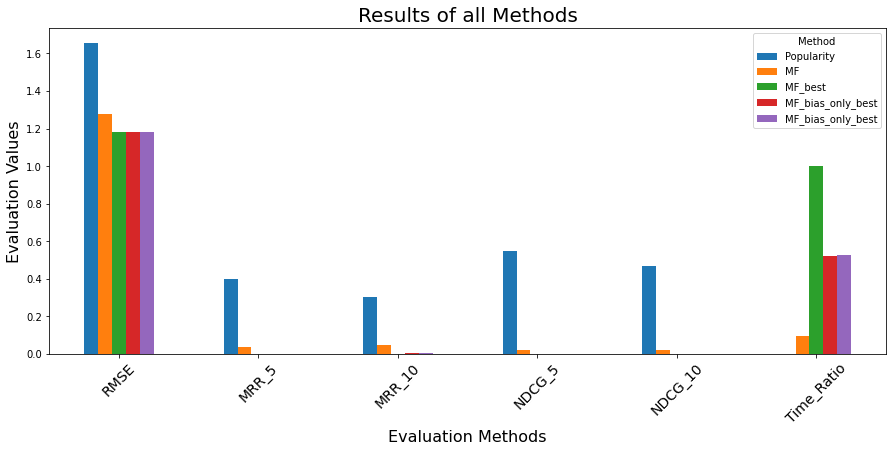

,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time_Ratio
Method,,,,,,
Popularity,1.654394,0.398485,0.304062,0.549121,0.468080,0.000990
MF,1.276480,0.039413,0.046862,0.018347,0.019170,0.094934
MF_best,1.183258,0.000619,0.001654,0.000294,0.000518,1.000000
MF_bias_only_best,1.183060,0.001096,0.003835,0.000509,0.001575,0.519329
MF_bias_only_best,1.183038,0.000742,0.003659,0.000366,0.001543,0.526571


In [55]:
final_results_backup = final_results.copy()
final_results_backup = final_results_backup.set_index('Method')
final_results_backup['Time_Ratio'] = final_results_backup['Time']/final_results_backup['Time'].max()
final_results_backup.drop('Time', inplace=True, axis=1)

final_results_backup.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results_backup

The results 

<br><br><br><br><br><br><br>

## E. Discussion 

Describe your challenges and findings, including comparison between the algorithms as well as your recommendations for how to select the latent factor dimension, the contribution of regularization and pros\cons of the different algorithms.

In your comparison refer to the evaluation metrics, training and inference duration, learning convergence and additional aspects you find relevant.

`popularity bias:` Please refers to system recommends the movies with the most interactions without any personalization

`item cold-start problem:` Please refers to when movies added to the catalogue have either none or very little interactions while recommender rely on the movie’s interactions to make recommendations

`scalability issue:` Please refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database

### Answer
One of the challenges in building a recommandation system for movie rates was to optimise parameters for each model. These are called "hyper-parameters" and their usually chosen by creating a small subset from each one of these "model fixed" parameters, train the model for each permutation and then evaluate the model performance and accuracy by some evaluation metric.
This way, we were able to conclude which hyper-parameter, such as latent factor dimensions, leads us to the best model.
As for the the different methods we used:
Popularity based is relatively a very basic and intuitive model. It only reflects the recommandations based on all users prefrences, neglecting any relations between features in the latent space, that is, the features that characterize each movie.
The results yielded for popularity were good (compared to the other models, according to the received results). This is probably due to the fact a lot of the movie features are depanded. The high correlation between features to general user prefrences can also consider to be rather intuitive, and that can explain why this model seemed to have accomplished sufficient results in a reasonable amount of time.
Saying that, it is important to emphasize that the results we got for all models were quite poor. We are assuming that we have faced some problem with some of the implementations along the way. This is why we would like to focus on comparing the models to each other, rather than talking about the results themselves.
As for the matrix factorization model - the computational power was without a doubt the highest of all. It has yielded descent results. It was hard to trace a valid comparison path between this model to the others, since we've got a very high diversity between the different evaluations.
We could see that the bias only model results were as well descent (supposing, again, that there was an error in our implementation and the "baseline" can be scaled up to reflect the same division between the defferent models but with higher results). It is strongly shown that the computational power required for bias only as compared to the regular MF model was much lower.
To conclude, the model of popularity based seems to be very trust worthy. It had proved to achieve high results with very low computational power.

`MRR VS nDCG`

**MRR**  

`Pros:`   

First pro of the MRR method is in its simplicity - that in turn provides us with ability to provide results faster. That is an advantage in case of large databases or in case the user has to choose only one product. 


`Cons:`    
The major problem with MRR is in its measuring only the first item recommended to the user. For example - two recommended lists - one with only one item the user chose and the other with 100 items the user chose, will receive the same rank if the first recommended item was relevant to the user.

The second con here is the need to sort and compare the recommended list to the user's preference. For example, if we want to check a very large list of movies/products, it will take a lot of time to sort the data. Nevertheless, it will be less time to sort the data in comparison to the NDCG method. 

The third con is that it doesn't take into account the difference in preferability of the user - for example - if he chose the second item in the recommended list, but it is way way less preferable than the first item, the MRR will be the same as in a case in which the user like item #1 and item #2 more or less the same. 


**NDCG**  
`Pros:`  

The major advantage in the NDCG is in its ability to overocme the MRR's last mentioned disadvantage - it takes into account the ranking (or the relevancy) of the user to the recommended list. The Normalization problem provides us a way to compare the recommendation to the most preferable option by the user. 


`Cons:`  
The major con here is in the resources needed to calculate the score. For each user we need to sort the rankings - once by the user's preferences and once by the recommender. That takes a long time in cases of large data sets. 

Another con here is that NDCG is not relevant for items that have 0/1 scores (like/dislike). In that case the algorithm has no advantage.

<br><br><br><br>

# Question 4: 


## Item similarity & explainability 
a)	Suggest a method to find similarity between items. Demonstrate the approach on a set of 5 item pairs of your choice based on item representation by your best matrix factorization model. Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach. 

b)	Select two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model. Demonstrate your estimation, using few items from the dataset and the items side information available in the dataset and\or external information. 


**Find similarity between items and demonstrate the approach on a set of 3 item triplets of your choice based on item representation by your one of your top3 matrix factorization model.**
  
**Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach.**

In [56]:
# best_model_df = results.loc[results.sort_values(by=["RMSE"]).index[:1]]
# best_model_df.head()

In [57]:
# train again the best MF model, using the best hyper-params - 

n_iterations = 20
convergence = 0.001 #best_model_df['Convergence'].values
latent_factors = 20 #best_model_df['Latent_factors'].values
regularization = 1 #best_model_df['Regularization'].values
learning_rate = 0.1 #best_model_df['Learning_Rate'].values

best_model = MF(train.values, n_factors=latent_factors)
best_model.fit(n_iterations=n_iterations, learning_rate=learning_rate, regularization=regularization, convergence=convergence, verbose=False)

In [58]:
pd.DataFrame(best_model.predict())

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.722925,3.528204,3.527829,3.528353,3.528228,3.526789,3.740735,3.726193,3.643701,3.687679,...,3.525918,3.903862,3.650882,3.546255,3.552937,3.521552,3.769644,3.550743,3.723685,3.665619
1,3.805769,3.610999,3.610998,3.610999,3.610999,3.610999,3.823357,3.808634,3.726363,3.770521,...,3.612653,3.992268,3.739002,3.637768,3.639940,3.611678,3.860265,3.644034,3.814243,3.752718
2,3.723109,3.528341,3.528320,3.528350,3.528343,3.528260,3.740710,3.725998,3.643714,3.687861,...,3.529774,3.909285,3.656039,3.554599,3.557040,3.528592,3.777151,3.560759,3.731133,3.669812
3,4.506655,4.311875,4.311945,4.311847,4.311871,4.312143,4.524201,4.509445,4.427215,4.471407,...,4.314255,4.694216,4.440885,4.340310,4.341605,4.313945,4.562634,4.346902,4.516591,4.454409
4,3.723047,3.528295,3.528156,3.528352,3.528305,3.527762,3.740718,3.726063,3.643709,3.687800,...,3.528521,3.907512,3.654225,3.551801,3.555710,3.526194,3.774566,3.557457,3.728657,3.668423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,4.276202,4.081432,4.081424,4.081435,4.081433,4.081404,4.293794,4.279075,4.196800,4.240954,...,4.083006,4.462586,4.209330,4.108019,4.110285,4.081959,4.330537,4.114248,4.284511,4.223060
939,3.723088,3.528326,3.528263,3.528351,3.528330,3.528088,3.740713,3.726020,3.643712,3.687840,...,3.529338,3.908673,3.655416,3.553637,3.556578,3.527768,3.776268,3.559587,3.730280,3.669337
940,4.036549,3.841778,3.841779,3.841777,3.841777,3.841786,4.054135,4.039412,3.957142,4.001300,...,3.843453,4.223077,3.969811,3.868593,3.870741,3.842496,4.091086,3.874867,4.045064,3.983520
941,4.138243,3.943473,3.943472,3.943473,3.943473,3.943472,4.155831,4.141109,4.058838,4.102995,...,3.945122,4.324734,4.071472,3.970230,3.972409,3.944143,4.192730,3.976493,4.146707,4.085186


<b>** DUE TO SOME PROBLEM IN CALCULATION IN THE MF MODEL - WE MADE THE CALCULATIONS USING THE RATINGS MATRIX **</b>

**Known methods to find similarity between items are:**
- Pearson Corellation  
- Cosine Similarity 
- Mean Difference
- L2 Distance

**Please implement them using numpy package:** 
(for example: np.linalg)


In [59]:
def get_item2vec(mf: pd.DataFrame ,i: int):
    '''
    receives mf predicted ratings df of the best mf model
    '''
    return mf.loc[:,i]

def get_pearson_similarity(a, b):
    '''
    Returns pearson coefficient for 2 variables a and b, each has the same number of observastions. 
    * If we want to use more than 2 variables we need to return a different place from the array that np.corrcoef returns. *
    
    https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html
    
    :param a: np array consisting of the observations of 1 variable 
    :type a: 1d np array
    :param b: np array consisting of the observations of 1 variable 
    :type b: 1d np array
    :return: the Pearson correlation r score of the two arrays
    :rtype: float
    '''
    pearson_matrix = np.corrcoef(a, b)
    return pearson_matrix[0, 1]


def get_cosine_similarity(a, b):
    '''
    The function receives two vectors of the same size and returns the cosine similarity between them.
    
    '''
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim


def get_mean_diff_similarity(a1, a2):
    
    mean_a1 = np.mean(a1)
    mean_a2 = np.mean(a2)    
    return mean_a1 - mean_a2
    

def get_l2_similarity(a1, a2):
    '''
    Calculates the L2 distance between 2 points
    '''
    return np.linalg.norm(a1 - a2)

**For the next step, please choose your favorite method.**  

**Please compare 3 triplets of movies, and for each triplet create this:**   
Create a dataframe same as the example

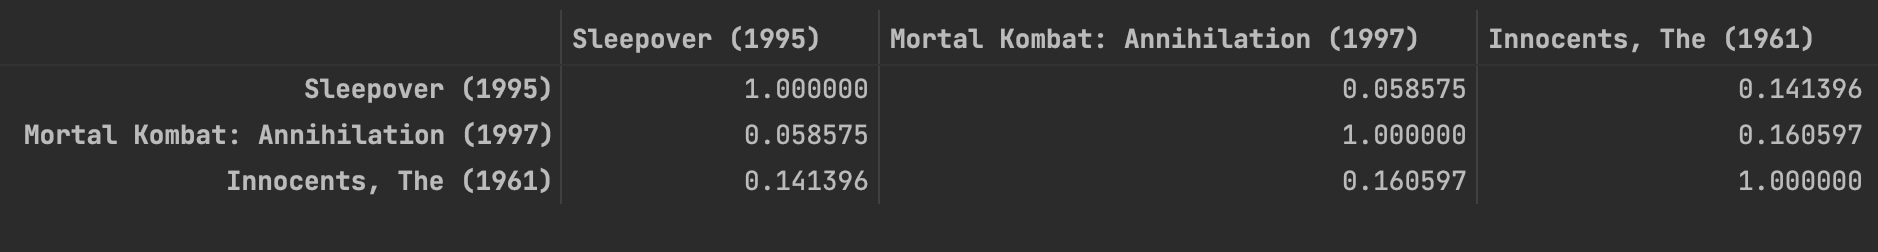

### Answer:
The methods we chose were the cosine similarity due to its precise similairty calculation compared to the mean and 12 similarity methods. 

The triplets we chose were random for the 1st triplet, similar Disney movies for the second triplet, and similar action-superheros movies for the 3rd triplet. 

In [60]:
def create_similarity_df(best_model: pd.DataFrame, chosen_movies_series: pd.Series):
    '''
    Receives the ratings df and the chosen movies series. 
    Ratings df can be either true or the predicted.
    The chosen movies series is a series consisting only the movies' id's (as the index) and the names of the movies that to which we want to check similarity. 
    
    Function returns the similarity df as defined in quesiton.
    
    '''
    rows, columns = chosen_movies_series.size, chosen_movies_series.size
    
    chosen_movies_indices, chosen_movies_names = chosen_movies_series.index, chosen_movies_series.values
        
    similarity_df = pd.DataFrame(columns=chosen_movies_names, index=chosen_movies_names)
        
    for r in range(rows):
        for c in range(columns):
            similarity_df.iloc[r][c] = get_cosine_similarity(get_item2vec(best_model, chosen_movies_indices[r]), get_item2vec(best_model, chosen_movies_indices[c]))
    
    return similarity_df

In [61]:
movies_names = np.array(df_items.movie_title.values)
movies_names_size = movies_names.size
all_movies_names = pd.Series(df_items.movie_title.values)
all_movies_names.index += 1
all_movies_names

1                                Toy Story (1995)
2                                GoldenEye (1995)
3                               Four Rooms (1995)
4                               Get Shorty (1995)
5                                  Copycat (1995)
                          ...                    
1678                            Mat' i syn (1997)
1679                             B. Monkey (1998)
1680                         Sliding Doors (1998)
1681                          You So Crazy (1994)
1682    Scream of Stone (Schrei aus Stein) (1991)
Length: 1682, dtype: object

**First Triplet:**

The first triplet we chose is juat a random one, to show that there is no similarrity between different movies:

In [62]:
# choosing random movies:

random_size = 3

rng = np.random.default_rng()
chosen_movies_indices_1 = rng.choice(movies_names_size, size=random_size, replace=False)
chosen_movies_indices_1

array([1340,  354,   25])

In [63]:
chosen_movies_series_1 = all_movies_names[chosen_movies_indices_1]
chosen_movies_series_1

1340       Crude Oasis, The (1995)
354     Wedding Singer, The (1998)
25            Birdcage, The (1996)
dtype: object

In [69]:
similarity_df = create_similarity_df(pd.DataFrame (best_model.predict()), chosen_movies_series_1)
# similarity_df = create_similarity_df(ratings, chosen_movies_series_1)

similarity_df

,"Crude Oasis, The (1995)","Wedding Singer, The (1998)","Birdcage, The (1996)"
"Crude Oasis, The (1995)",1,0.999713,0.999715
"Wedding Singer, The (1998)",0.999713,1,1
"Birdcage, The (1996)",0.999715,1,1


#### Explanation:
We can see that there is no similarity between the chosen movies - due to the fact that the choose on movies was random. In that case we expect to see no similarity between totally different movies.

**Second Triplet:**

In this time, we went through the names of the movies and actively chose similar movies - according to the target audience (by group, age, etc.), theme, genre, year the movie came out, etc.

In order to better examine the results we chose 5 Disney movies as follows:

The movies we chose are:

In [70]:
chosen_movies_indices_2 = [95, 422, 993, 71, 1, 225]
chosen_movies_series_2 = all_movies_names[chosen_movies_indices_2]
chosen_movies_series_2

95                             Aladdin (1992)
422    Aladdin and the King of Thieves (1996)
993                           Hercules (1997)
71                      Lion King, The (1994)
1                            Toy Story (1995)
225                     101 Dalmatians (1996)
dtype: object

For this triplet we will receive:

In [71]:
similarity_df = create_similarity_df(ratings, chosen_movies_series_2)
similarity_df

,Aladdin (1992),Aladdin and the King of Thieves (1996),Hercules (1997),"Lion King, The (1994)",Toy Story (1995),101 Dalmatians (1996)
Aladdin (1992),1,0.29947,0.329664,0.753162,0.581974,0.376131
Aladdin and the King of Thieves (1996),0.29947,1,0.144545,0.268542,0.225559,0.19632
Hercules (1997),0.329664,0.144545,1,0.344687,0.353507,0.262089
"Lion King, The (1994)",0.753162,0.268542,0.344687,1,0.552822,0.403309
Toy Story (1995),0.581974,0.225559,0.353507,0.552822,1,0.409386
101 Dalmatians (1996),0.376131,0.19632,0.262089,0.403309,0.409386,1


#### Explanation:

Here we can see muchly higher similarity between the movies! Nevertheless, we can see that there is still a big difference. This could be due to the fact that the target audience is still al ittle bit different between the movies - while all movies address kids, Hercules is more boys orientedm while 101 Dalmaties is more girls oriented. We can see that between the Lion King and Aladdin the similarity is higher - due to the wider target audience those two movies address to.

In addition, the movies ar esimilar due to the years they went out - all of the movies were similar in their features and properties (animated movies, made by Disney, targeted more or less the same ages). In addition, the culture didn't change much between those years - so it is very likely that kids/children at that time liked the same movies, and Disney understood that and released a number of movies similar to each other to win the kid's attention. 

**Third Triplet**

In this time, we also went through the names of the movies and actively chose similar movies - this time we chose action movies with superheros. We expect to see a great similairty between them - mostly address grownup men who like action movies.

The movies we chose are:

In [72]:
chosen_movies_indices_3 = [426, 403, 541, 1274]
chosen_movies_series_3 = all_movies_names[chosen_movies_indices_3]
chosen_movies_series_3

426     Transformers: The Movie, The (1986)
403                           Batman (1989)
541                    Mortal Kombat (1995)
1274                       Robocop 3 (1993)
dtype: object

For this triplet we will receive:

In [73]:
similarity_df = create_similarity_df(ratings, chosen_movies_series_3)
similarity_df

,"Transformers: The Movie, The (1986)",Batman (1989),Mortal Kombat (1995),Robocop 3 (1993)
"Transformers: The Movie, The (1986)",1,0.295508,0.339508,0.137085
Batman (1989),0.295508,1,0.414877,0.184244
Mortal Kombat (1995),0.339508,0.414877,1,0.312555
Robocop 3 (1993),0.137085,0.184244,0.312555,1


The similarity is smaller than what we expected! 

<br><br><br>
**Find two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model.**

**Tip:**  
would we get a good seperation for different genres?  
For example, here we can see that this is not a good seperation.




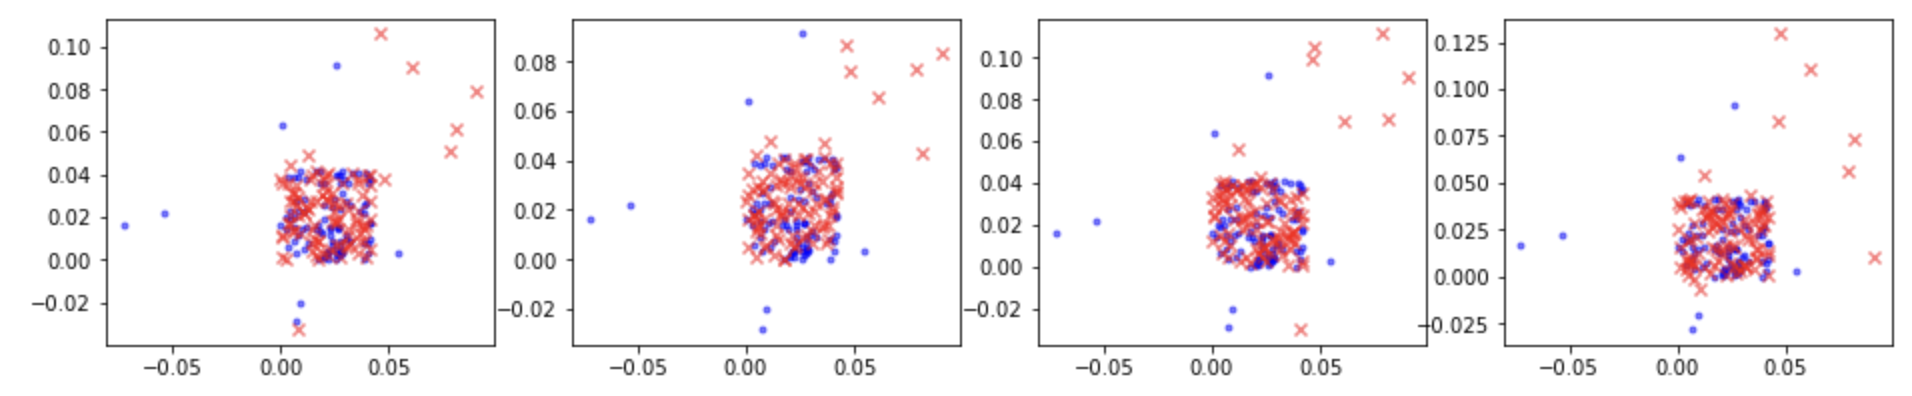